In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from astropy.io import fits

Gemini Sky Background data  
(http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/skybg_50_10.dat)

In [9]:
def getGeminiBackground(start,end,machine='coho'):
    wavelength = []
    flux = []
    geminiloc=''

    if machine=='chinook':
        geminiloc='/Users/lokhorst/Documents/Eagle/Gemini_skybackground.dat'
    elif machine=='coho':
        geminiloc='/Users/deblokhorst/Documents/Dragonfly/HalphaScripts/Gemini_skybackground.dat'
        #'/Users/deblokhorst/Documents/Dragonfly/DragonflyHalpha/Notebooks/Gemini_skybackground.dat'

    with open(geminiloc,'r') as f:
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                wavelength.append(tmp[0])
                flux.append(tmp[1])
                
    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
    
    # since spacings are even, can just take the average of the flux array and times it by the total bandwidth
    # return np.mean(flux[start_ind:end_ind])*(wavelength[end_ind]-wavelength[start_ind])    
    return wavelength[start_ind:end_ind],flux[start_ind:end_ind]

In [10]:
def getBackgroundMean(start,end,machine='coho'):
    wavelength = []
    flux = []
    geminiloc=''
    if machine=='chinook':
        geminiloc='/Users/lokhorst/Documents/Eagle/Gemini_skybackground.dat'
    elif machine=='coho':
        geminiloc='/Users/deblokhorst/Documents/Dragonfly/HalphaScripts/Gemini_skybackground.dat'
        #'/Users/deblokhorst/Documents/Dragonfly/DragonflyHalpha/Notebooks/Gemini_skybackground.dat'

    with open(geminiloc,'r') as f:
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                wavelength.append(tmp[0])
                flux.append(tmp[1])
                
    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
    
    total=0
    for index in np.arange(start_ind,end_ind):
        total = total + (flux[index]*(wavelength[index+1]-wavelength[index]))
    
    return total /(wavelength[end_ind]-wavelength[start_ind])

(0, 1.5)

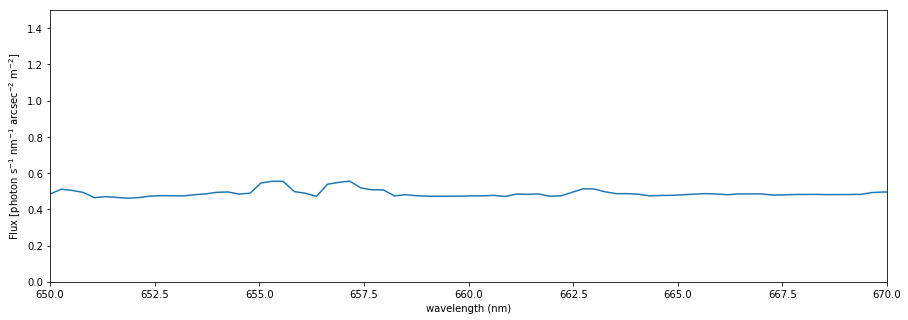

In [11]:
machine='chinook'
wavelength_GEM,flux_GEM=getGeminiBackground(600.,900.,machine=machine)
fig = plt.figure(figsize=(15.,5.))
plt.plot(wavelength_GEM, flux_GEM)
plt.ylabel(r'Flux [photon s$^{-1}$ nm$^{-1}$ arcsec$^{-2}$ m$^{-2}$]')
plt.xlabel('wavelength (nm)')
plt.xlim(650,670)
plt.ylim(0,1.5)

UVES Sky Background data  
(http://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html)

In [13]:
def getUVESBackground(filename):
    hdulist = fits.open(filename)
    flux = hdulist[0].data
    
    CRPIX1 = hdulist[0].header['CRPIX1']
    CRVAL1 = hdulist[0].header['CRVAL1']
    CDELT1 = hdulist[0].header['CDELT1']
    print(CRPIX1,CRVAL1,CDELT1)
    hdulist.close()
        
    begin = CRVAL1 - CRPIX1*CDELT1   
    end = begin + len(flux)*CDELT1
    wavelength = np.arange(begin,end,CDELT1)
    #print(len(wavelength),len(flux))
    return wavelength,flux

(-945.0, 5817.06402, 0.03482)
(-2318.0, 6605.74752, 0.04064)
wavelength array is one element longer than the flux array.  Shortening the wavelength array.


(6263, 6863)

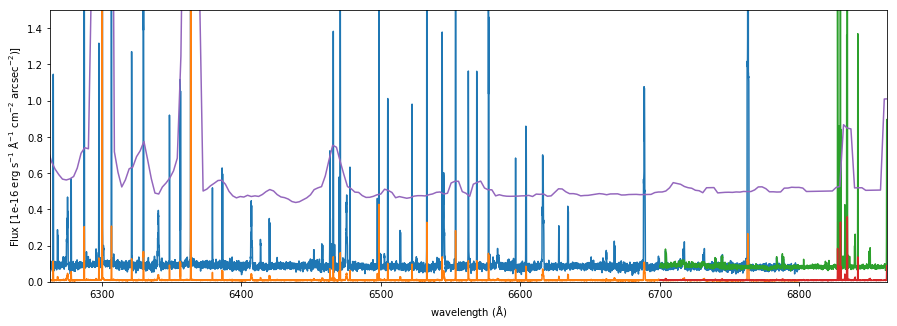

In [22]:
filename1 = "fluxed_sky_580U.fits"
filename2 = "fluxed_sky_860L.fits"


if machine=='coho':
    uvesloc = '/Users/deblokhorst/Dropbox/UVES_Sky_Background/UVES_sky_all/'
elif machine =='chinook':
    uvesloc = '/Users/lokhorst/Dropbox/UVES_Sky_Background/UVES_sky_all/'
else:
    print 'No machine specified!'
    
wavelength_UVES1,flux_UVES1=getUVESBackground(uvesloc+filename1)
wavelength_UVES2,flux_UVES2=getUVESBackground(uvesloc+filename2)

fig = plt.figure(figsize=(15.,5.))
for wavelength,flux in zip([wavelength_UVES1,wavelength_UVES2],[flux_UVES1,flux_UVES2]):
    if len(wavelength)==(len(flux)+1):
        print('wavelength array is one element longer than the flux array.  Shortening the wavelength array.')
        wavelength = wavelength[0:-1]
    plt.plot(wavelength,flux)
    plt.plot(wavelength,flux/10.)
plt.ylabel(r'Flux [1e-16 erg s$^{-1}$ $\mathrm{\AA}^{-1}$ cm$^{-2}$ arcsec$^{-2}$)]')
plt.xlabel('wavelength ($\mathrm{\AA}$)')
plt.plot(wavelength_GEM*10., flux_GEM)

plt.ylim(0,1.5)
start = 6563 - 300
end = 6563 + 300
plt.xlim(start,end)

Keck Sky Background
https://www2.keck.hawaii.edu/inst/mosfire/sky_lines.html

Want to compare the UVES and Gemini sky spectra.  To do this need to convert to the same units:  photon / s / cm^2 / arcsec^2 / nm.

Gemini is in: photon / s / **m^2** / arcsec^2 / nm 

* (m / 100cm) ^2

UVES is in: 1e-16 **erg** / s / cm^2 / arcsec^2 / **Angstrom**

* 1 photon / ( h c / lambda ) erg
* 10 Angstrom / nm

In [55]:
flux_GEM_units = flux_GEM * (1/100.**2) 
flux_UVES1_units = flux_UVES1 *10**-16* ((wavelength_UVES1*10**-10)/(const.h.to('erg s').value * const.c.to('m/s').value)) * 10.
flux_UVES2_units = flux_UVES2 *10**-16* ((wavelength_UVES2[0:-1]*10**-10)/(const.h.to('erg s').value * const.c.to('m/s').value)) * 10.

In [30]:
const.h.to('erg s')

<Quantity 6.62606957e-27 erg s>

In [37]:
const.c.to('m/s')

<Quantity 299792458.0 m / s>

The mean at 657nm is: 5.06192123288e-05


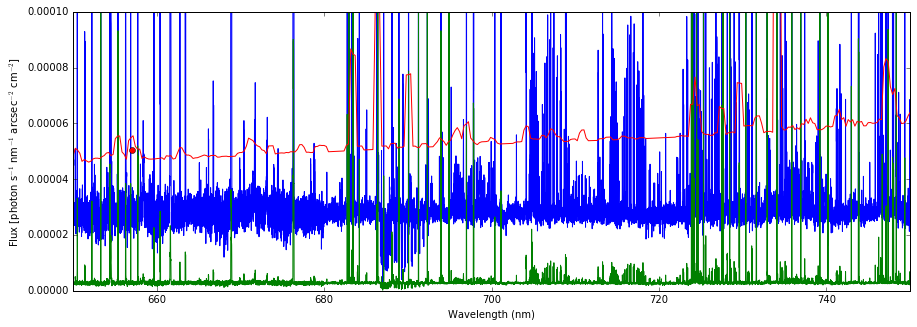

In [69]:
fig = plt.figure(figsize=(15.,5.))

meanat657 = getBackgroundMean(656.,659.)* (1/100.**2) 
print('The mean at 657nm is: %s'%meanat657)
plt.plot(wavelength_UVES1/10.,flux_UVES1_units,'b')
plt.plot(wavelength_UVES2[0:-1]/10.,flux_UVES2_units,'b')
plt.plot(wavelength_UVES1/10.,flux_UVES1_units/10.,'g')
plt.plot(wavelength_UVES2[0:-1]/10.,flux_UVES2_units/10.,'g')
plt.plot(wavelength_GEM,flux_GEM_units,'r')
plt.plot(657,meanat657,'ro')
plt.ylim(0,0.0001)
plt.xlim(650,750)
plt.ylabel(r'Flux [photon s$^{-1}$ nm$^{-1}$ arcsec$^{-2}$ cm$^{-2}$]')
#plt.xlabel('Wavelength (nm)')

In [78]:
print(5.2e-5 * (206265)**2)


2212353.0117


In [19]:
## code snippet to change SB units ##
from astropy import constants as const
from astropy import units as u

SB_cgs = 10**-20 *u.erg / u.arcsec**2 / u.cm**2 / u.s
SB_ph = SB_cgs * 656.3e-9*u.m/(const.h.to('erg s') * const.c.to('m/s')) * (206265.*u.arcsec)**2/u.sr

In [20]:
SB_ph

<Quantity 140.5648689910946 1 / (cm2 s sr)>